In [14]:
import torch
import faiss 
import numpy as np
from scipy.io import mmread
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from sklearn.cluster import KMeans


In [15]:
#check cuda 
print(torch.cuda.is_available()) 
print(torch.version.cuda)
print(torch.__version__)

True
12.4
2.4.1


In [16]:
rawData = mmread('scRNA.mtx')
coo_matrix = rawData.tocoo()
print(coo_matrix)
print(coo_matrix.shape)

<COOrdinate sparse matrix of dtype 'float64'
	with 86422438 stored elements and shape (34619, 27180)>
  Coords	Values
  (30, 0)	878.85046
  (44, 0)	2636.5513
  (58, 0)	878.85046
  (74, 0)	878.85046
  (77, 0)	878.85046
  (109, 0)	878.85046
  (225, 0)	3515.4019
  (247, 0)	878.85046
  (272, 0)	878.85046
  (273, 0)	1318.2756
  (365, 0)	878.85046
  (366, 0)	2636.5513
  (421, 0)	878.85046
  (431, 0)	1757.7009
  (440, 0)	878.85046
  (442, 0)	5273.1025
  (499, 0)	16698.158
  (594, 0)	878.85046
  (649, 0)	1757.7009
  (688, 0)	878.85046
  (706, 0)	878.85046
  (831, 0)	1757.7009
  (835, 0)	2636.5513
  (867, 0)	878.85046
  (911, 0)	2636.5513
  :	:
  (32162, 27179)	142.14685
  (32202, 27179)	88.841736
  (32298, 27179)	177.68347
  (32423, 27179)	59.227825
  (32425, 27179)	177.68347
  (32564, 27179)	88.841736
  (33015, 27179)	177.68347
  (33454, 27179)	177.68347
  (33504, 27179)	177.68347
  (33538, 27179)	177.68347
  (33578, 27179)	88.841736
  (33636, 27179)	177.68347
  (33647, 27179)	284.01257
  (33

#### Process And Modify Data

In [17]:
def clean_and_split_data(coo_matrix, max_number):
    #get only non-zero values
    total_nnz = coo_matrix.nnz 

    # Ensure max_nnz doesn’t exceed total
    if max_number >= total_nnz:
        raise ValueError(f"max_nnz ({max_number}) must be less than total non-zero elements ({total_nnz})")
    
    rows = coo_matrix.row
    cols = coo_matrix.col
    data = coo_matrix.data
    
    selected_indices = np.arange(max_number)  

    selected = coo_matrix.__class__(
        (data[selected_indices], (rows[selected_indices], cols[selected_indices])),
        shape=coo_matrix.shape
    )
    
    return selected

processed_data = clean_and_split_data(coo_matrix=coo_matrix, max_number=1000000)
print(processed_data)

<COOrdinate sparse matrix of dtype 'float64'
	with 1000000 stored elements and shape (34619, 27180)>
  Coords	Values
  (30, 0)	878.85046
  (44, 0)	2636.5513
  (58, 0)	878.85046
  (74, 0)	878.85046
  (77, 0)	878.85046
  (109, 0)	878.85046
  (225, 0)	3515.4019
  (247, 0)	878.85046
  (272, 0)	878.85046
  (273, 0)	1318.2756
  (365, 0)	878.85046
  (366, 0)	2636.5513
  (421, 0)	878.85046
  (431, 0)	1757.7009
  (440, 0)	878.85046
  (442, 0)	5273.1025
  (499, 0)	16698.158
  (594, 0)	878.85046
  (649, 0)	1757.7009
  (688, 0)	878.85046
  (706, 0)	878.85046
  (831, 0)	1757.7009
  (835, 0)	2636.5513
  (867, 0)	878.85046
  (911, 0)	2636.5513
  :	:
  (14418, 293)	125.2383
  (14428, 293)	62.61915
  (14431, 293)	62.61915
  (14434, 293)	152.82574
  (14435, 293)	3256.1958
  (14439, 293)	23.63185
  (14444, 293)	250.4766
  (14445, 293)	62.61915
  (14449, 293)	219.16702
  (14461, 293)	125.2383
  (14465, 293)	62.61915
  (14466, 293)	125.2383
  (14467, 293)	62.61915
  (14471, 293)	62.61915
  (14484, 293)	62.

#### Graph Construction

In [18]:
def cell_graph(data, threshold):

    gene_expression = data.data
    
    x = np.asarray(gene_expression, dtype=np.float32)
    x = x.reshape(-1, 1) #reshape to 1D array

    #move calculations to gpu
    gpu_resource_manager = faiss.StandardGpuResources() 
    similarity_object = faiss.IndexFlatL2(1)
    similarity_object_in_gpu = faiss.index_cpu_to_gpu(gpu_resource_manager, 0, similarity_object)

    #check gpu allocation
    print(similarity_object_in_gpu.is_trained)  
    print(f"FAISS index type: {type(similarity_object_in_gpu)}") 


    similarity_object_in_gpu.add(x)
    k=2
    distances, indices = similarity_object_in_gpu.search(x, k + 1)
    
    edge_index_list = []
    outliers = []
    
    for i in range(len(gene_expression)):
        nearest_neighbors = indices[i, 1:k+1]  
        neighbor_distances = distances[i, 1:k+1]
        
        for j, dist in zip(nearest_neighbors, neighbor_distances):
            if dist <= threshold ** 2:
                edge_index_list.append((i, j))
            else:
                outliers.append(int(j))
    
    # Convert edges to torch tensor
    edge_index_np = np.array(edge_index_list).T
    edge_index = torch.tensor(edge_index_np, dtype=torch.long) if edge_index_np.size > 0 else torch.empty((2, 0), dtype=torch.long)

    cleaned_outliers = list(set(outliers))
    print(cleaned_outliers)

    x_tensor = torch.tensor(x, dtype=torch.float32)
    pyg_data = Data(edge_index=edge_index, x=x_tensor)
    
    return pyg_data

data = cell_graph(data=processed_data,threshold=500)

True
FAISS index type: <class 'faiss.swigfaiss.GpuIndexFlat'>
[397700, 696586, 223116, 163986, 823956, 4763, 932510, 490399, 177955, 284331, 995116, 157360, 283697, 585907, 24500, 340662, 703416, 845753, 223163, 372669, 774463, 395840, 744770, 995401, 291661, 217679, 646351, 341846, 617691, 507749, 507750, 744808, 877161, 321899, 75244, 642539, 552686, 659695, 800882, 951416, 961276]


Data(x=[1000, 1]) - 1000 nodes with 1 feature 

Data(edge_index=[2, 19980]) - 2 Dimensonal Vector representing connections

#### Graph Visualization

In [19]:
def visualize_graph():
    pass

#### Graph Neural Network

○ GraphSAGE works by gathering features from neighbouring nodes 

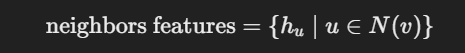

○ Aggergate these features from neighbouring nodes - from the nueral network 

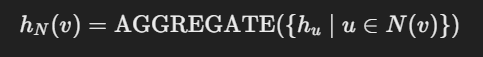

○ Finally combines this with the target nodes own features 

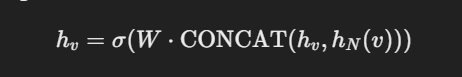 

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super(GraphSAGE, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))  
        
        for _ in range(num_layers - 2):  
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        
        self.convs.append(SAGEConv(hidden_channels, out_channels))  

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]: 
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)
        x = self.convs[-1](x, edge_index) 
        return x  

In [ ]:
def loss_function(embeddings, edge_index):
    src, dst = edge_index 
    sim_loss = F.mse_loss(embeddings[src], embeddings[dst])  

    return sim_loss

In [ ]:
def contrastive_loss(embeddings, batch_size=1024):
    device = embeddings.device
    num_nodes = embeddings.shape[0]
    loss = 0.0
    count = 0

    for i in range(0, num_nodes, batch_size):
        batch_emb = embeddings[i : i + batch_size]
        sim_matrix = torch.matmul(batch_emb, embeddings.T)
        loss += -torch.mean(F.log_softmax(sim_matrix, dim=-1))
        count += 1

    return loss / count 

In [37]:
def train(model, data, epochs=100, lr=0.00005):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        embeddings = model(data.x, data.edge_index)  
        loss = contrastive_loss(embeddings)
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return embeddings

In [38]:
def cluster_embeddings(embeddings, num_clusters=5):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings.detach().numpy())
    return cluster_labels

In [ ]:
#tranining 
in_channels = 1
hidden_channels = 64  
out_channels = 16  
num_layers = 4  

model = GraphSAGE(in_channels, hidden_channels, out_channels, num_layers)
embeddings = train(model, data)


cluster_labels = cluster_embeddings(embeddings)